Install (Colab) + Imports + Paths

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# If running on Colab, uncomment these:
# !pip install -q scikit-learn==1.3.2 imbalanced-learn==0.11.0 xgboost==2.0.3 shap==0.44.1 seaborn==0.13.2

import os, json, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from pathlib import Path
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score,
                             accuracy_score, precision_score, recall_score, f1_score, RocCurveDisplay)
from sklearn.feature_selection import mutual_info_classif

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from xgboost import XGBClassifier

import joblib

# Paths
DATA_PATH   = Path("/content/drive/MyDrive/Colab Notebooks/FDM/Bank_Churn_prediction/Churn_Modelling_with_missing.csv")  # adjust if needed
MODELS_DIR  = Path("/content/drive/MyDrive/Colab Notebooks/FDM/Bank_Churn_prediction/models"); MODELS_DIR.mkdir(exist_ok=True)
REPORTS_DIR = Path("/content/drive/MyDrive/Colab Notebooks/FDM/Bank_Churn_prediction/reports"); REPORTS_DIR.mkdir(exist_ok=True)


Load + Basic Column

In [ ]:
df = pd.read_csv(DATA_PATH)

# Drop obvious non-predictive identifiers
id_cols = ["RowNumber", "CustomerId", "Surname"]
df = df.drop(columns=[c for c in id_cols if c in df.columns])

# Keep canonical feature names to match your app:
# ['CreditScore','Geography','Gender','Age','Tenure','Balance','NumOfProducts',
#  'HasCrCard','IsActiveMember','EstimatedSalary','Exited']

# Strip whitespace in string cells & remove stray underscores in VALUES (not column names)
for col in df.select_dtypes(include=['object']).columns:
    df[col] = (df[col].astype(str)
                       .str.strip()
                       .str.replace(r"_+", " ", regex=True))

# Quick sanity
display(df.head())
print(df.shape, df.isna().sum().to_dict())


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619.0,France,Female,42.0,2,0.00,1,1,1,101348.88,1
1,608.0,Spain,Female,41.0,1,83807.86,1,0,1,112542.58,0
2,502.0,France,Female,42.0,8,159660.80,3,1,0,113931.57,1
3,699.0,France,Female,39.0,1,0.00,2,0,0,93826.63,0
4,850.0,Spain,Female,43.0,2,125510.82,1,1,1,79084.10,0


(10000, 11) {'CreditScore': 2, 'Geography': 0, 'Gender': 0, 'Age': 2, 'Tenure': 0, 'Balance': 2, 'NumOfProducts': 0, 'HasCrCard': 0, 'IsActiveMember': 0, 'EstimatedSalary': 2, 'Exited': 0}


Garbage-Value Rules + NaN strategy (ffill/bfill, then typed imputation)

In [ ]:
df_clean = df.copy()

# Simple "garbage" detectors → set to NaN (domain heuristics)
def to_nan_if(cond):
    return np.nan if cond else None

# Example rules (tweak if needed)
df_clean.loc[df_clean["Age"].lt(18) | df_clean["Age"].gt(100), "Age"] = np.nan
df_clean.loc[df_clean["CreditScore"].lt(0) | df_clean["CreditScore"].gt(1000), "CreditScore"] = np.nan
df_clean.loc[df_clean["Tenure"].lt(0) | df_clean["Tenure"].gt(50), "Tenure"] = np.nan
df_clean.loc[df_clean["Balance"].lt(0), "Balance"] = np.nan
df_clean.loc[df_clean["EstimatedSalary"].lt(0), "EstimatedSalary"] = np.nan

# Forward fill then backward fill (row-order based)
df_clean = df_clean.fillna(method="ffill").fillna(method="bfill")

# Target
y = df_clean["Exited"].astype(int).values
X = df_clean.drop(columns=["Exited"])


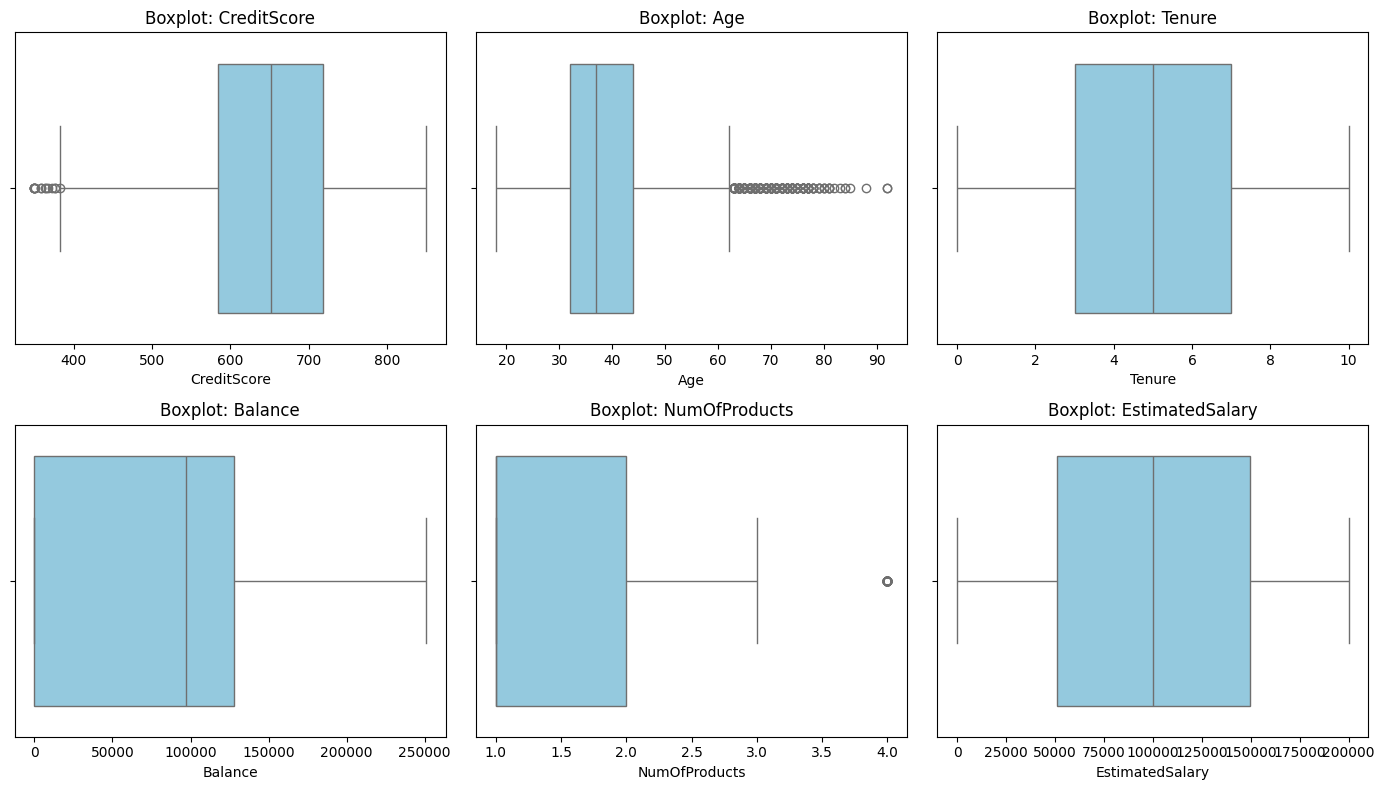

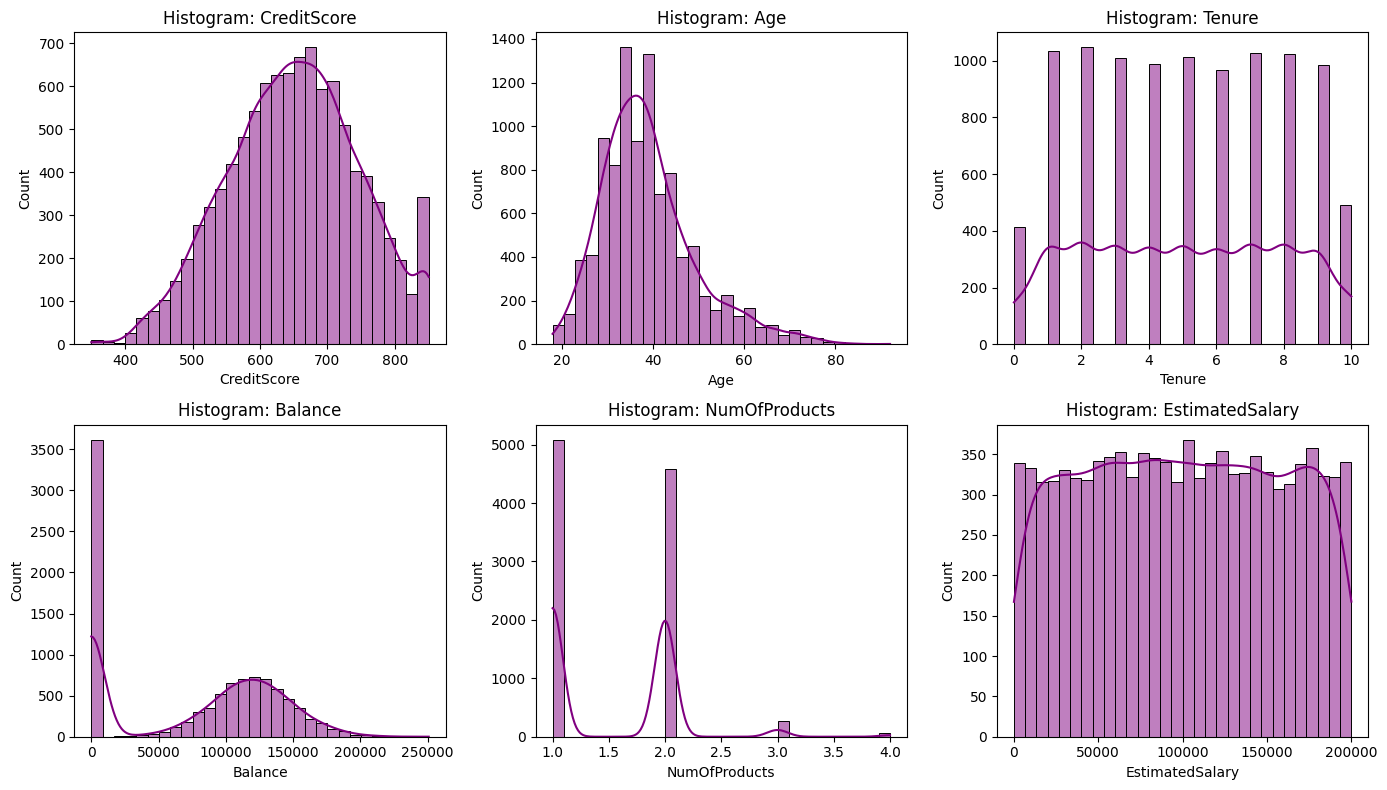

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Boxplots to visually inspect outliers
plt.figure(figsize=(14,8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2,3,i)
    sns.boxplot(x=df_clean[col], color="skyblue")
    plt.title(f"Boxplot: {col}")
plt.tight_layout()
plt.show()

# Histograms to see distribution before outlier removal
plt.figure(figsize=(14,8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2,3,i)
    sns.histplot(df_clean[col], kde=True, color="purple", bins=30)
    plt.title(f"Histogram: {col}")
plt.tight_layout()
plt.show()


Train/Test Split (no leakage)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

X_train.shape, X_test.shape, y_train.mean(), y_test.mean()


((8000, 10), (2000, 10), np.float64(0.20375), np.float64(0.2035))

Outlier Removal (IQR) Train-only

In [ ]:
train = X_train.copy()
train["Exited"] = y_train

num_cols = ["CreditScore","Age","Tenure","Balance","NumOfProducts","EstimatedSalary"]
cat_cols = ["Geography","Gender"]

def iqr_mask(df, cols, k=1.5):
    mask = pd.Series(True, index=df.index)
    for c in cols:
        q1, q3 = df[c].quantile([0.25, 0.75])
        iqr = q3 - q1
        lower, upper = q1 - k*iqr, q3 + k*iqr
        mask &= df[c].between(lower, upper) | df[c].isna()
    return mask

mask = iqr_mask(train, num_cols, k=1.5)
trimmed = train[mask].copy()

print(f"Removed outliers: {len(train) - len(trimmed)} rows from training ({100*(1-len(trimmed)/len(train)):.2f}%)")

# Update X_train, y_train
y_train = trimmed["Exited"].values
X_train = trimmed.drop(columns=["Exited"])


Removed outliers: 360 rows from training (4.50%)


Skewness & Kurtosis (report only)

In [ ]:
skew_kurt = pd.DataFrame({
    "feature": num_cols,
    "skewness": [X_train[c].skew() for c in num_cols],
    "kurtosis": [X_train[c].kurtosis() for c in num_cols],
}).sort_values("skewness", key=lambda s: s.abs(), ascending=False)

display(skew_kurt)
skew_kurt.to_csv(REPORTS_DIR / "skew_kurtosis.csv", index=False)


,feature,skewness,kurtosis
1,Age,0.501773,0.024984
4,NumOfProducts,0.404623,-0.947853
3,Balance,-0.139286,-1.490371
0,CreditScore,-0.050251,-0.484145
2,Tenure,0.010840,-1.169884
5,EstimatedSalary,0.006598,-1.174681


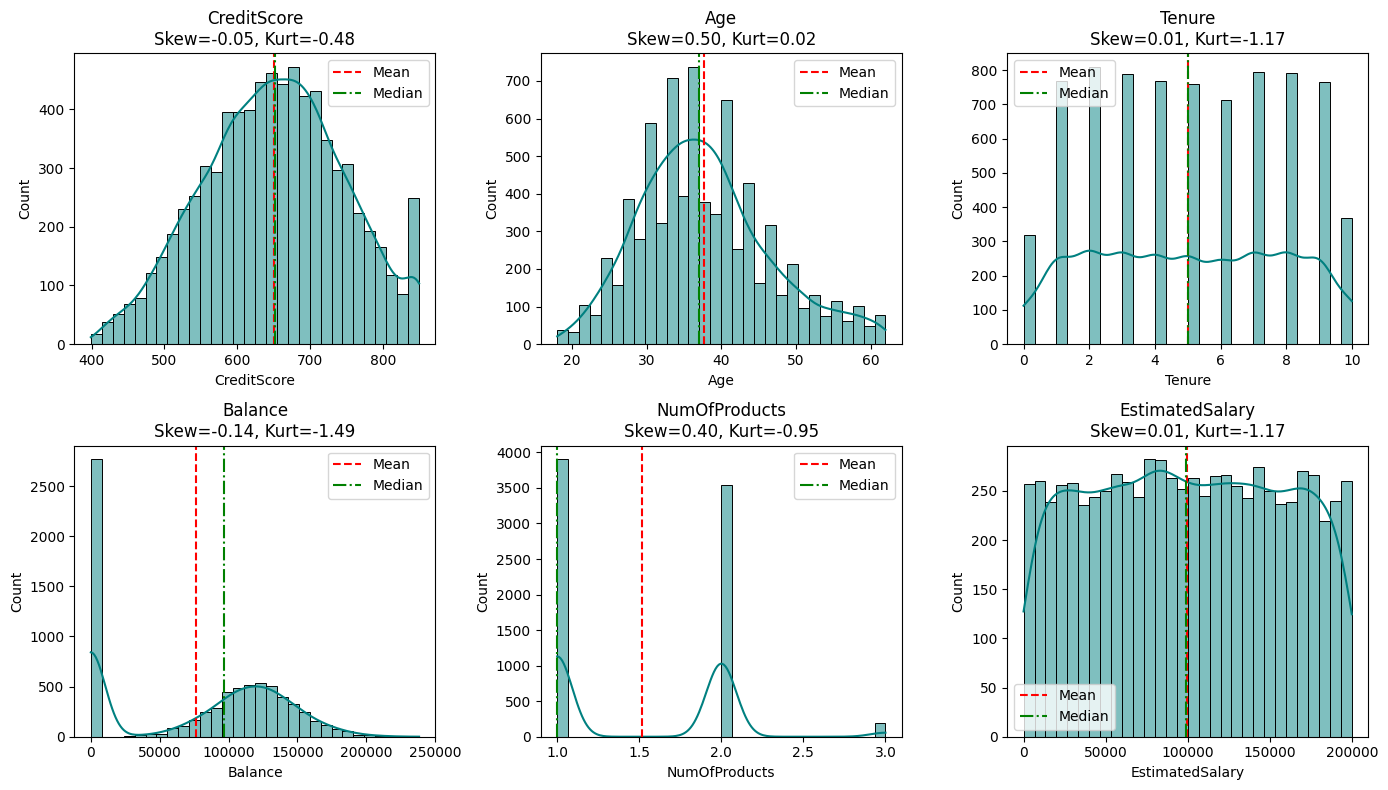

In [ ]:
plt.figure(figsize=(14,8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2,3,i)
    sns.histplot(X_train[col], kde=True, bins=30, color="teal")
    plt.axvline(X_train[col].mean(), color="red", linestyle="--", label="Mean")
    plt.axvline(X_train[col].median(), color="green", linestyle="-.", label="Median")
    plt.title(f"{col}\nSkew={X_train[col].skew():.2f}, Kurt={X_train[col].kurtosis():.2f}")
    plt.legend()
plt.tight_layout()
plt.show()


Correlation Heatmap (coolwarm)

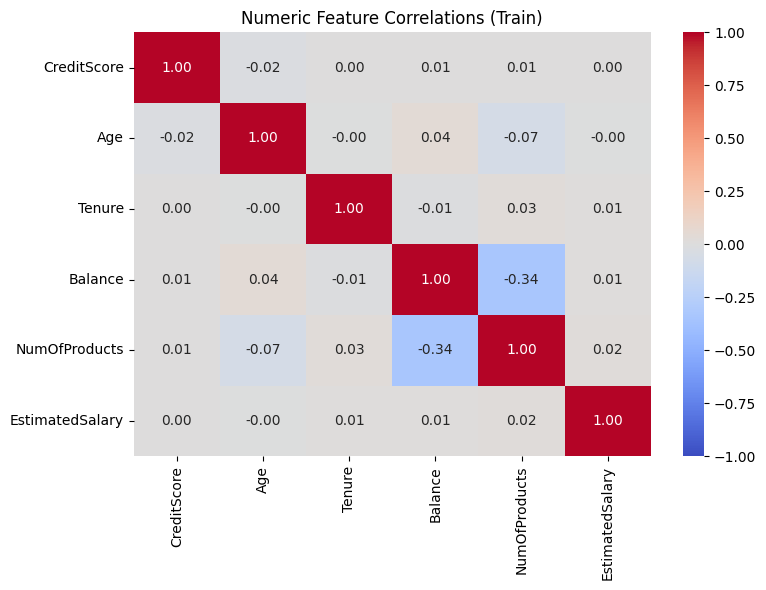

In [ ]:
plt.figure(figsize=(8,6))
corr = X_train[num_cols].corr()
sns.heatmap(corr, cmap="coolwarm", annot=True, fmt=".2f", vmin=-1, vmax=1)
plt.title("Numeric Feature Correlations (Train)")
plt.tight_layout()
plt.show()


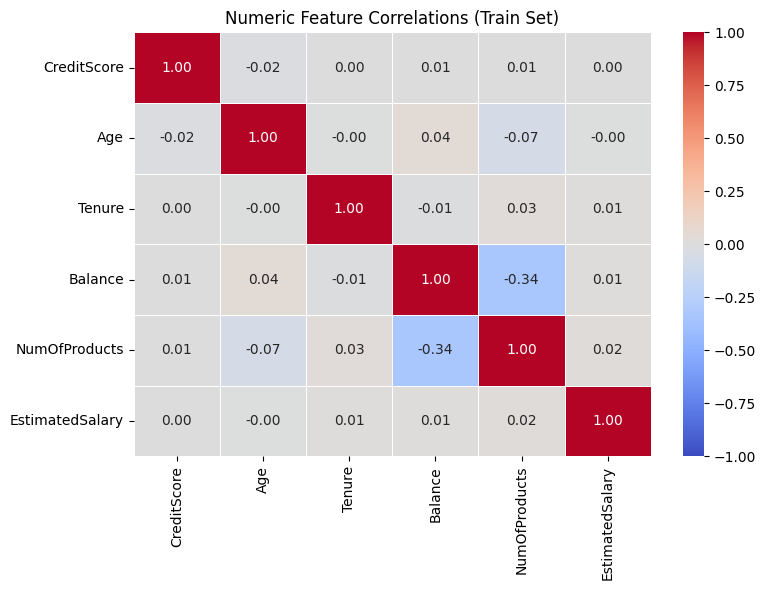

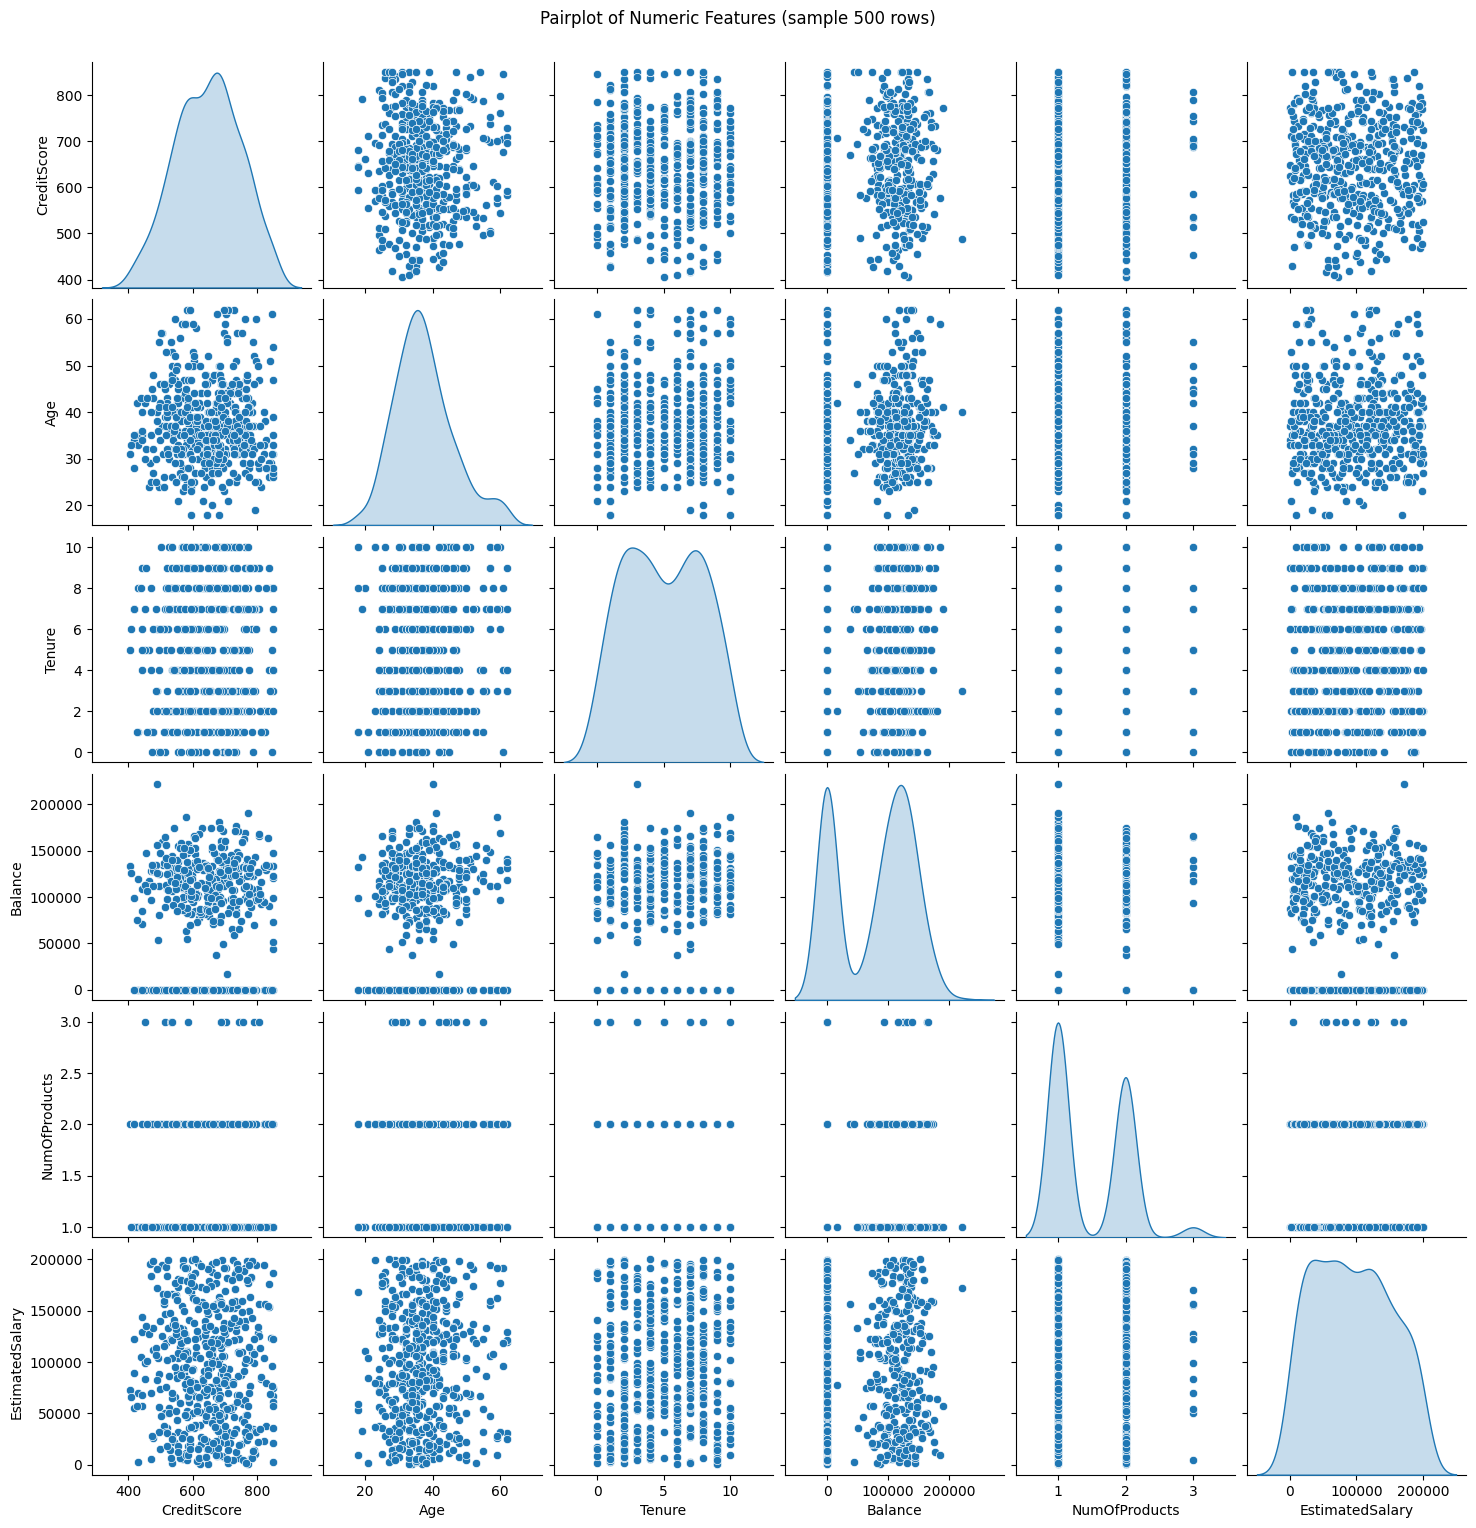

In [ ]:
# Numeric correlations
plt.figure(figsize=(8,6))
corr = X_train[num_cols].corr()
sns.heatmap(corr, cmap="coolwarm", annot=True, fmt=".2f", vmin=-1, vmax=1, linewidths=0.5)
plt.title("Numeric Feature Correlations (Train Set)")
plt.tight_layout()
plt.show()

# Pairplot for key numeric features (optional heavy viz)
sns.pairplot(X_train[num_cols].sample(500), diag_kind="kde")
plt.suptitle("Pairplot of Numeric Features (sample 500 rows)", y=1.02)
plt.show()


Preprocessor (typed imputers + optional power transform + scaling + one-hot)

In [ ]:
# Optional: power transform for skewed numeric features (Yeo-Johnson works with zeros/negatives)
skewed = skew_kurt.loc[skew_kurt["skewness"].abs() > 1, "feature"].tolist()

num_steps = []
num_steps.append(("imputer", SimpleImputer(strategy="mean")))
if len(skewed) > 0:
    num_steps.append(("power", PowerTransformer(method="yeo-johnson")))
num_steps.append(("scaler", StandardScaler()))

num_pipe = Pipeline(num_steps)

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols),
], remainder="drop")

# Helper to recover OHE feature names
def get_feature_names(preprocessor):
    num_features = num_cols
    cat = preprocessor.named_transformers_["cat"]["onehot"]
    cat_features = list(cat.get_feature_names_out(cat_cols))
    return num_features + cat_features


Mutual Information (with preprocessed features)

In [ ]:
# Fit preprocessor on train only
preprocessor.fit(X_train)

Xtr = preprocessor.transform(X_train)
feature_names = get_feature_names(preprocessor)

mi = mutual_info_classif(Xtr, y_train, discrete_features=[fn.startswith(tuple(cat_cols)) for fn in feature_names])
mi_df = pd.DataFrame({"feature": feature_names, "MI": mi}).sort_values("MI", ascending=False)
display(mi_df.head(20))
mi_df.to_csv(REPORTS_DIR / "mutual_information.csv", index=False)

# Optional: select features with MI > 0 threshold (demo uses 0.0 to keep all)
mi_keep = mi_df[mi_df["MI"] > 0.0]["feature"].tolist()
print(f"Keeping {len(mi_keep)} / {len(feature_names)} features (MI>0)")


,feature,MI
1,Age,0.070392
4,NumOfProducts,0.062836
7,Geography_Germany,0.015363
3,Balance,0.011275
6,Geography_France,0.006310
10,Gender_Male,0.005234
9,Gender_Female,0.005234
5,EstimatedSalary,0.004358
8,Geography_Spain,0.001458
2,Tenure,0.000000


Keeping 9 / 11 features (MI>0)


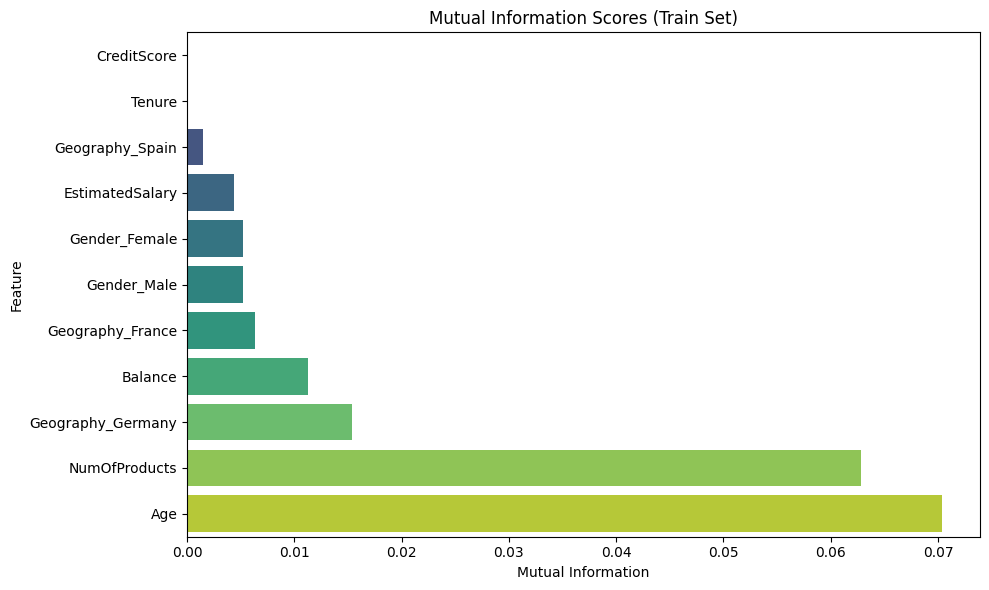

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(x="MI", y="feature", data=mi_df.sort_values("MI", ascending=True), palette="viridis")
plt.title("Mutual Information Scores (Train Set)")
plt.xlabel("Mutual Information")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


Balanced Pipelines (SMOTE inside pipeline)

In [ ]:
def make_pipeline(clf):
    return ImbPipeline(steps=[
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("clf", clf)
    ])

models = {
    "RandomForest":  RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1, class_weight=None),
    "XGB":           XGBClassifier(n_estimators=400, max_depth=5, learning_rate=0.05, subsample=0.8,
                                   colsample_bytree=0.8, reg_lambda=1.0, random_state=42, eval_metric="logloss"),
    "DecisionTree":  DecisionTreeClassifier(random_state=42),
    "KNN":           KNeighborsClassifier(n_neighbors=11),
    "GaussianNB":    GaussianNB(),
    "SVC":           SVC(kernel="rbf", C=1.0, probability=True, random_state=42)
}


Evaluation Helpers (confusion matrix + metrics)

In [ ]:
def evaluate(model_name, pipe, X_train, y_train, X_test, y_test, threshold=0.5):
    pipe.fit(X_train, y_train)
    proba = pipe.predict_proba(X_test)[:,1]
    y_pred = (proba >= threshold).astype(int)

    cm = confusion_matrix(y_test, y_pred)
    auc = roc_auc_score(y_test, proba)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"\n=== {model_name} @ threshold={threshold:.2f} ===")
    print(f"AUC: {auc:.4f}  ACC: {acc:.4f}  PREC: {prec:.4f}  REC: {rec:.4f}  F1: {f1:.4f}")
    print(cm)
    print(classification_report(y_test, y_pred, digits=4))

    # ROC Curve
    RocCurveDisplay.from_predictions(y_test, proba)
    plt.title(f"ROC: {model_name}")
    plt.show()

    return {"auc":auc, "acc":acc, "precision":prec, "recall":rec, "f1":f1, "cm":cm, "proba":proba}


Train/Evaluate All Base Models


=== RandomForest @ threshold=0.50 ===
AUC: 0.8283  ACC: 0.8200  PREC: 0.5528  REC: 0.6044  F1: 0.5775
[[1394  199]
 [ 161  246]]
              precision    recall  f1-score   support

           0     0.8965    0.8751    0.8856      1593
           1     0.5528    0.6044    0.5775       407

    accuracy                         0.8200      2000
   macro avg     0.7246    0.7398    0.7316      2000
weighted avg     0.8265    0.8200    0.8229      2000



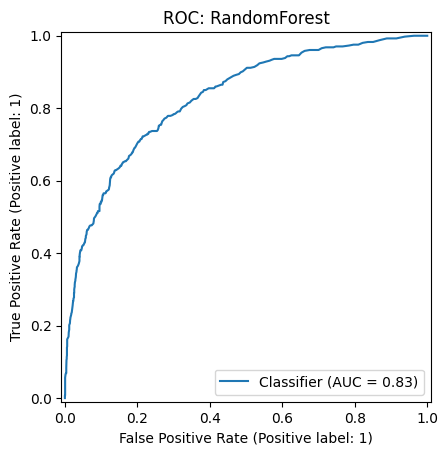


=== XGB @ threshold=0.50 ===
AUC: 0.8405  ACC: 0.8400  PREC: 0.6101  REC: 0.5921  F1: 0.6010
[[1439  154]
 [ 166  241]]
              precision    recall  f1-score   support

           0     0.8966    0.9033    0.8999      1593
           1     0.6101    0.5921    0.6010       407

    accuracy                         0.8400      2000
   macro avg     0.7533    0.7477    0.7505      2000
weighted avg     0.8383    0.8400    0.8391      2000



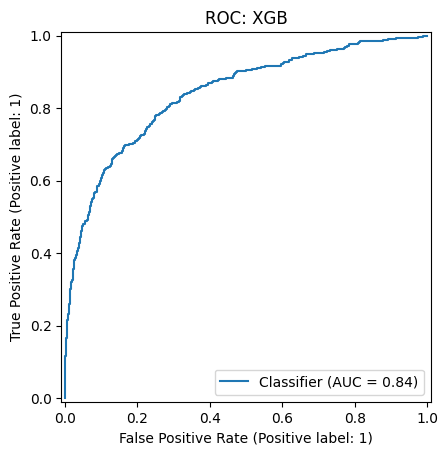


=== DecisionTree @ threshold=0.50 ===
AUC: 0.6676  ACC: 0.7590  PREC: 0.4239  REC: 0.5135  F1: 0.4644
[[1309  284]
 [ 198  209]]
              precision    recall  f1-score   support

           0     0.8686    0.8217    0.8445      1593
           1     0.4239    0.5135    0.4644       407

    accuracy                         0.7590      2000
   macro avg     0.6463    0.6676    0.6545      2000
weighted avg     0.7781    0.7590    0.7672      2000



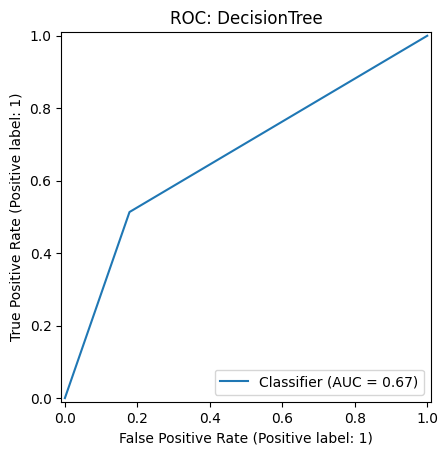


=== KNN @ threshold=0.50 ===
AUC: 0.7993  ACC: 0.7365  PREC: 0.4148  REC: 0.7174  F1: 0.5257
[[1181  412]
 [ 115  292]]
              precision    recall  f1-score   support

           0     0.9113    0.7414    0.8176      1593
           1     0.4148    0.7174    0.5257       407

    accuracy                         0.7365      2000
   macro avg     0.6630    0.7294    0.6716      2000
weighted avg     0.8102    0.7365    0.7582      2000



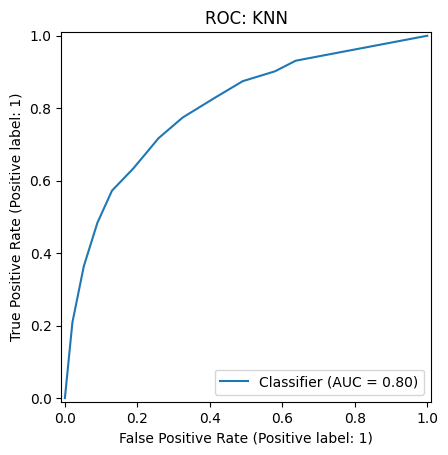


=== GaussianNB @ threshold=0.50 ===
AUC: 0.7612  ACC: 0.6815  PREC: 0.3555  REC: 0.6953  F1: 0.4705
[[1080  513]
 [ 124  283]]
              precision    recall  f1-score   support

           0     0.8970    0.6780    0.7723      1593
           1     0.3555    0.6953    0.4705       407

    accuracy                         0.6815      2000
   macro avg     0.6263    0.6866    0.6214      2000
weighted avg     0.7868    0.6815    0.7108      2000



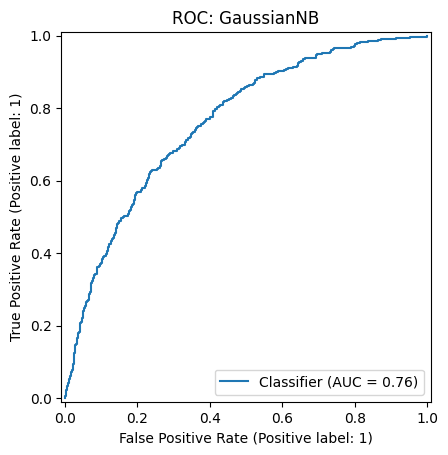


=== SVC @ threshold=0.50 ===
AUC: 0.8271  ACC: 0.7780  PREC: 0.4712  REC: 0.7445  F1: 0.5771
[[1253  340]
 [ 104  303]]
              precision    recall  f1-score   support

           0     0.9234    0.7866    0.8495      1593
           1     0.4712    0.7445    0.5771       407

    accuracy                         0.7780      2000
   macro avg     0.6973    0.7655    0.7133      2000
weighted avg     0.8314    0.7780    0.7941      2000



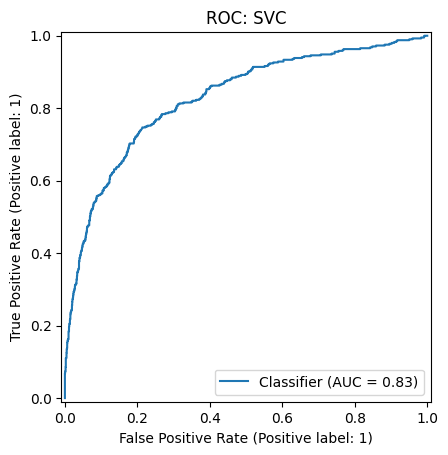

[('XGB', np.float64(0.8404521624860608)),
 ('RandomForest', np.float64(0.8283229300178454)),
 ('SVC', np.float64(0.8270766914834712)),
 ('KNN', np.float64(0.7992599687514942)),
 ('GaussianNB', np.float64(0.76121113409249)),
 ('DecisionTree', np.float64(0.6676167693116846))]

In [ ]:
results = {}
for name, clf in models.items():
    pipe = make_pipeline(clf)
    results[name] = evaluate(name, pipe, X_train, y_train, X_test, y_test, threshold=0.50)

sorted([(k, v["auc"]) for k,v in results.items()], key=lambda x: x[1], reverse=True)


GridSearchCV (Model Optimization for top candidates)-Tuning RF, XGB, SVC using AUC for selection.

Define parameter grids

In [ ]:
param_grids = {
    "RandomForest": {
        "clf__n_estimators": [200, 400, 600],
        "clf__max_depth": [None, 10, 20],
        "clf__min_samples_split": [2, 5],
    },
    "XGB": {
        "clf__n_estimators": [300, 500],
        "clf__max_depth": [4, 6],
        "clf__learning_rate": [0.03, 0.06],
        "clf__subsample": [0.8, 1.0],
        "clf__colsample_bytree": [0.8, 1.0],
        "clf__reg_lambda": [1.0, 2.0],
    },
    "SVC": {
        "clf__C": [0.5, 1.0, 2.0],
        "clf__gamma": ["scale", 0.1, 0.01],
        "clf__kernel": ["rbf"]
    }
}


Train RandomForest

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipe_rf = make_pipeline(models["RandomForest"])
gs_rf = GridSearchCV(pipe_rf, param_grids["RandomForest"], scoring="roc_auc", cv=cv, n_jobs=-1, verbose=1)
gs_rf.fit(X_train, y_train)

print(f"\nRandomForest best AUC: {gs_rf.best_score_:.4f} | params: {gs_rf.best_params_}")
best_rf = gs_rf.best_estimator_


Fitting 5 folds for each of 18 candidates, totalling 90 fits

RandomForest best AUC: 0.8439 | params: {'clf__max_depth': 10, 'clf__min_samples_split': 5, 'clf__n_estimators': 600}


Train XGB

In [ ]:
pipe_xgb = make_pipeline(models["XGB"])
gs_xgb = GridSearchCV(pipe_xgb, param_grids["XGB"], scoring="roc_auc", cv=cv, n_jobs=-1, verbose=1)
gs_xgb.fit(X_train, y_train)

print(f"\nXGB best AUC: {gs_xgb.best_score_:.4f} | params: {gs_xgb.best_params_}")
best_xgb = gs_xgb.best_estimator_


Fitting 5 folds for each of 64 candidates, totalling 320 fits

XGB best AUC: 0.8466 | params: {'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.03, 'clf__max_depth': 4, 'clf__n_estimators': 300, 'clf__reg_lambda': 2.0, 'clf__subsample': 0.8}


Train SVC

In [ ]:
pipe_svc = make_pipeline(models["SVC"])
gs_svc = GridSearchCV(pipe_svc, param_grids["SVC"], scoring="roc_auc", cv=cv, n_jobs=-1, verbose=1)
gs_svc.fit(X_train, y_train)

print(f"\nSVC best AUC: {gs_svc.best_score_:.4f} | params: {gs_svc.best_params_}")
best_svc = gs_svc.best_estimator_


Fitting 5 folds for each of 9 candidates, totalling 45 fits

SVC best AUC: 0.8315 | params: {'clf__C': 0.5, 'clf__gamma': 0.1, 'clf__kernel': 'rbf'}


Collect models

In [ ]:
best_models = {
    "RandomForest": best_rf,
    "XGB": best_xgb,
    "SVC": best_svc
}

Evaluate on test set

In [ ]:
leader, leader_auc = None, -1
for name, est in best_models.items():
    proba = est.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, proba)
    print(f"{name} Test AUC: {auc:.4f}")
    if auc > leader_auc:
        leader, leader_auc = name, auc

print(f"\n🏆 Best model: {leader} (Test AUC={leader_auc:.4f})")
best_estimator = best_models[leader]


RandomForest Test AUC: 0.8414
XGB Test AUC: 0.8501
SVC Test AUC: 0.8341

🏆 Best model: XGB (Test AUC=0.8501)


imports & quick sanity checks

In [ ]:
from sklearn.preprocessing import QuantileTransformer

Fit QuantileTransformers and save to disk

In [ ]:
cols = ["Balance", "EstimatedSalary", "CreditScore", "Age", "Tenure", "NumOfProducts"]

qt = {}
for col in cols:
    if col not in df.columns:
        raise KeyError(f"Column '{col}' not found in df.columns")
    qt[col] = QuantileTransformer(output_distribution="normal", random_state=42)
    qt[col].fit(df[[col]])   # fit on full dataset distribution (ok for app mapping)

out_path = MODELS_DIR / "quantile_transformers.pkl"
joblib.dump(qt, out_path)
print("Saved quantile transformers to:", out_path)


Saved quantile transformers to: /content/drive/MyDrive/Colab Notebooks/FDM/Bank_Churn_prediction/models/quantile_transformers.pkl


Define threshold-tuning helper (returns detailed gains too)

In [ ]:
def optimal_threshold(proba, y_true=None, c_contact=200.0, ltv=50000.0, save_rate=0.25, ts=None):
    """
    Find threshold t that maximizes expected gain:
      expected gain for flagged = p * save_rate * ltv  - c_contact
    Returns: best_t, best_gain, gains_list
    gains_list is list of tuples: (threshold, gain, n_flagged)
    """
    if ts is None:
        ts = np.linspace(0.1, 0.9, 41)
    best_t, best_gain = 0.5, -np.inf
    gains = []
    for t in ts:
        flag = proba >= t
        gain = ( (proba[flag] * save_rate * ltv).sum() ) - (flag.sum() * c_contact)
        gains.append((t, gain, int(flag.sum())))
        if gain > best_gain:
            best_gain, best_t = gain, t
    return best_t, best_gain, gains


Compute predicted probabilities on your test set

In [ ]:
# Make sure best_estimator and X_test exist in your session
proba_test = best_estimator.predict_proba(X_test)[:, 1]
print("proba_test shape:", proba_test.shape)
print("sample probabilities:", proba_test[:10])

proba_test shape: (2000,)
sample probabilities: [0.04343384 0.22216389 0.13416523 0.12959903 0.29230994 0.3361686
 0.16089556 0.36068746 0.5718062  0.18818955]


Run tuning and show top thresholds (tabular)

In [ ]:
t_star, gain, gains = optimal_threshold(proba_test, y_test, c_contact=200.0, ltv=50000.0, save_rate=0.25)
print(f"Suggested Sri Lanka decision threshold t* = {t_star:.2f}")
print(f"Expected gain at t*: {gain:,.0f} LKR")

# create DataFrame for easier inspection & sorting
gdf = pd.DataFrame(gains, columns=["threshold", "gain", "n_flagged"]).sort_values("gain", ascending=False).reset_index(drop=True)
gdf.head(10)   # show top 10 candidate thresholds


Suggested Sri Lanka decision threshold t* = 0.10
Expected gain at t*: 7,644,204 LKR


,threshold,gain,n_flagged
0,0.10,7644204.0,1585
1,0.12,7546938.5,1502
2,0.14,7436156.5,1424
3,0.16,7292613.5,1339
4,0.18,7116559.0,1247
5,0.20,6919028.0,1156
6,0.22,6760434.0,1091
7,0.24,6588666.5,1027
8,0.26,6419414.0,969
9,0.28,6214693.0,904


Save tuning results (pickle + csv)

In [ ]:
# Save a pickle for programmatic reuse and a CSV for quick viewing
joblib.dump({"t_star": t_star, "expected_gain": gain, "gains_df": gdf}, MODELS_DIR / "threshold_tuning_results.pkl")
gdf.to_csv(REPORTS_DIR / "threshold_tuning_summary.csv", index=False)
print("Saved threshold tuning results to:")
print(" -", MODELS_DIR / "threshold_tuning_results.pkl")
print(" -", REPORTS_DIR / "threshold_tuning_summary.csv")

Saved threshold tuning results to:
 - /content/drive/MyDrive/Colab Notebooks/FDM/Bank_Churn_prediction/models/threshold_tuning_results.pkl
 - /content/drive/MyDrive/Colab Notebooks/FDM/Bank_Churn_prediction/reports/threshold_tuning_summary.csv


Plot expected gain vs threshold (visual check)

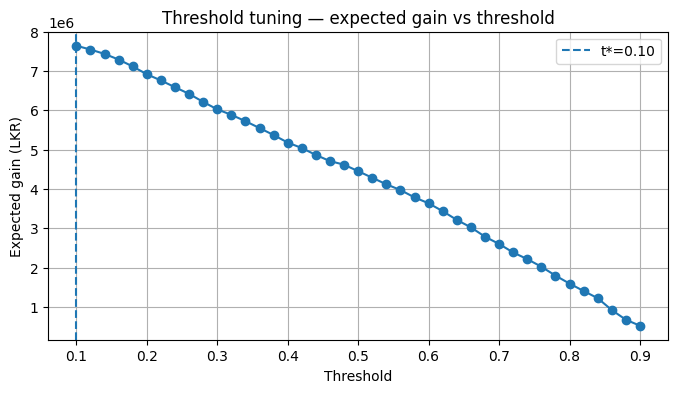

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(gdf["threshold"], gdf["gain"], marker="o")
plt.axvline(t_star, linestyle="--", label=f"t*={t_star:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Expected gain (LKR)")
plt.title("Threshold tuning — expected gain vs threshold")
plt.legend()
plt.grid(True)
plt.show()

Compare expected vs realized (using y_test)

In [ ]:
# This compares the expected gain formula with realized gain computed using y_test
flag = proba_test >= t_star
expected = (proba_test[flag] * 0.25 * 50000).sum() - flag.sum() * 200
realized = (y_test[flag] * 0.25 * 50000).sum() - flag.sum() * 200
print(f"Expected gain (model p): {expected:,.0f} LKR")
print(f"Realized gain (actual y_test): {realized:,.0f} LKR  (note: realized uses ground truth churners only)")

Expected gain (model p): 7,644,204 LKR
Realized gain (actual y_test): 4,633,000 LKR  (note: realized uses ground truth churners only)


Final Save (Model + Spec JSON)

In [ ]:
# Persist trained pipeline (preprocessor + SMOTE + classifier)
joblib.dump(best_estimator, MODELS_DIR / "churn_model.joblib")

# Feature spec with localization notes (for your app to show)
spec = {
    "model_name": f"{leader}",
    "metrics": {
        "test_roc_auc": float(roc_auc_score(y_test, best_estimator.predict_proba(X_test)[:,1]))
    },
    "localization": {
        "geography_mapping": {
            "Urban (Colombo Metro)": "Germany",
            "Semi-Urban (Kandy, Galle, Kurunegala)": "France",
            "Rural (Jaffna, Monaragala, Anuradhapura)": "Spain"
        },
        "currency": "LKR",
        "threshold": round(float(t_star), 2),
        "notes": "LKR inputs (Balance/EstimatedSalary) are mapped via QuantileTransformers to the model's distribution; no dataset retraining required."
    }
}
with open(MODELS_DIR / "feature_spec.json", "w") as f:
    json.dump(spec, f, indent=2)

print("Saved:", MODELS_DIR / "churn_model.joblib", MODELS_DIR / "quantile_transformers.pkl", MODELS_DIR / "feature_spec.json")


Saved: /content/drive/MyDrive/Colab Notebooks/FDM/Bank_Churn_prediction/models/churn_model.joblib /content/drive/MyDrive/Colab Notebooks/FDM/Bank_Churn_prediction/models/quantile_transformers.pkl /content/drive/MyDrive/Colab Notebooks/FDM/Bank_Churn_prediction/models/feature_spec.json


Confusion Matrix Plot (for the report)

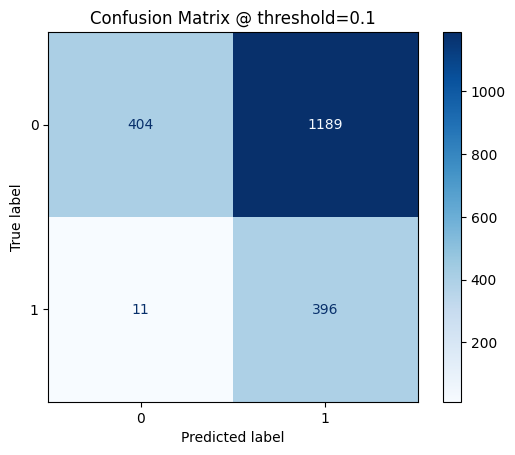

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
yhat = (proba_test >= spec["localization"]["threshold"]).astype(int)
ConfusionMatrixDisplay.from_predictions(y_test, yhat, cmap="Blues")
plt.title(f"Confusion Matrix @ threshold={spec['localization']['threshold']}")
plt.show()
